<a href="https://colab.research.google.com/github/mrinal35/Email-Response-Assistant/blob/main/K_meansvsFCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install h5py


In [6]:
import h5py
import numpy as np
import os

data_path = '/content/drive/MyDrive/1512427 (1).zip (Unzipped Files)/brainTumorDataPublic_1-766.zip (Unzipped Files)'

mat_files = [f for f in os.listdir(data_path) if f.endswith('.mat')]

def load_mat_file_h5py(file_path):
    with h5py.File(file_path, 'r') as mat_file:
        # Access the fields inside the structure
        image = np.array(mat_file['cjdata']['image'])
        tumor_mask = np.array(mat_file['cjdata']['tumorMask'])
        label = np.array(mat_file['cjdata']['label']).item()  # Extract as scalar
    return image, tumor_mask, label


image, tumor_mask, label = load_mat_file_h5py(os.path.join(data_path, mat_files[0]))
print(f'Image shape: {image.shape}, Tumor Mask shape: {tumor_mask.shape}, Label: {label}')


Image shape: (512, 512), Tumor Mask shape: (512, 512), Label: 1.0


In [7]:
import cv2

def preprocess_image(image):

    image = image / np.max(image)
    image_resized = cv2.resize(image, (256, 256))
    return image_resized

# Example preprocessing
image_preprocessed = preprocess_image(image)


In [8]:
def flatten_image(image):
    return image.flatten().reshape(-1, 1)

# Flatten the preprocessed image
flattened_image = flatten_image(image_preprocessed)


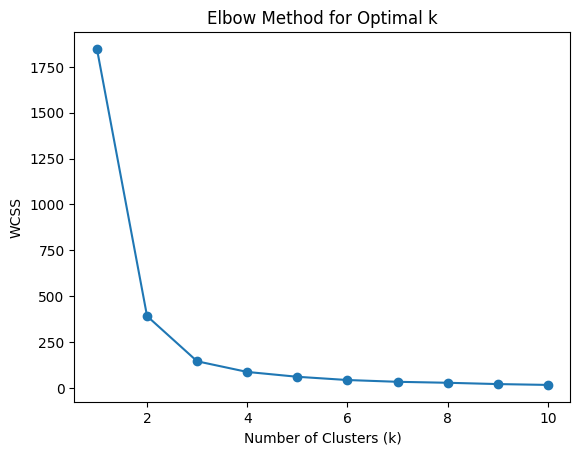

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def apply_kmeans(flattened_image, max_k=10):
    wcss = []  # Within-Cluster Sum of Squares (WCSS)
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(flattened_image)
        wcss.append(kmeans.inertia_)
    return wcss

# Calculate WCSS for k from 1 to 10
wcss = apply_kmeans(flattened_image, max_k=10)

# Plot the Elbow Curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.show()


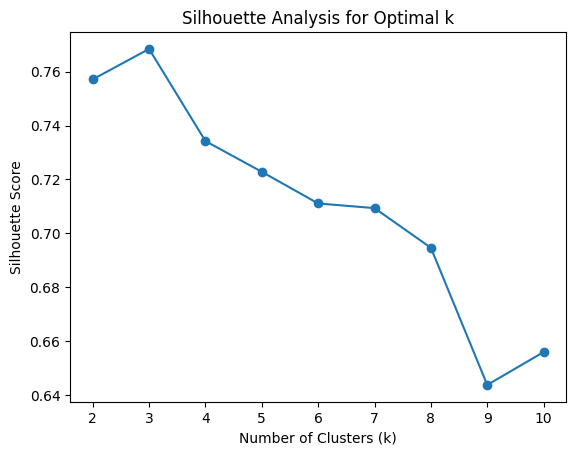

In [10]:
from sklearn.metrics import silhouette_score

def silhouette_analysis(flattened_image, max_k=10):
    silhouette_scores = []
    for k in range(2, max_k + 1):  # Silhouette score is valid for k > 1
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(flattened_image)
        silhouette_avg = silhouette_score(flattened_image, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    return silhouette_scores

# Silhouette Scores for k from 2 to 10
silhouette_scores = silhouette_analysis(flattened_image, max_k=10)

# Plot the Silhouette Scores
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


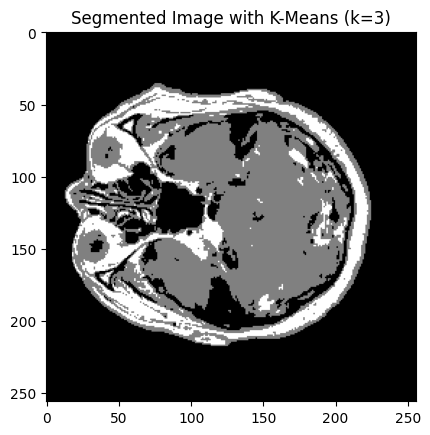

In [11]:
optimal_k = 3 #from Silhouette Analysis
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(flattened_image)

# Reshape the segmented image back to 2D
segmented_image = kmeans.labels_.reshape(image_preprocessed.shape)

plt.imshow(segmented_image, cmap='gray')
plt.title(f'Segmented Image with K-Means (k={optimal_k})')
plt.show()


Compare with Ground Truth Tumor Mask

In [12]:
import cv2

# Resize the segmented image to match the tumor mask shape (512, 512)
segmented_image_resized = cv2.resize(segmented_image, (tumor_mask.shape[1], tumor_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

# Check the new shape of the resized segmented image
print(f'Resized Segmented image shape: {segmented_image_resized.shape}')
print(f'Tumor mask shape: {tumor_mask.shape}')

# Flatten both arrays after ensuring they are the same size
segmented_image_flattened = segmented_image_resized.flatten()
tumor_mask_flattened = tumor_mask.flatten()

# Function to calculate Dice Coefficient
def dice_coefficient(segmented, ground_truth):
    intersection = np.sum(segmented * ground_truth)
    return (2. * intersection) / (np.sum(segmented) + np.sum(ground_truth))

# Calculate the Dice Coefficient
dice_score = dice_coefficient(segmented_image_flattened, tumor_mask_flattened)
print(f'Dice Coefficient: {dice_score}')


Resized Segmented image shape: (512, 512)
Tumor mask shape: (512, 512)
Dice Coefficient: 0.057915391935572665


In [13]:
!pip install scikit-fuzzy

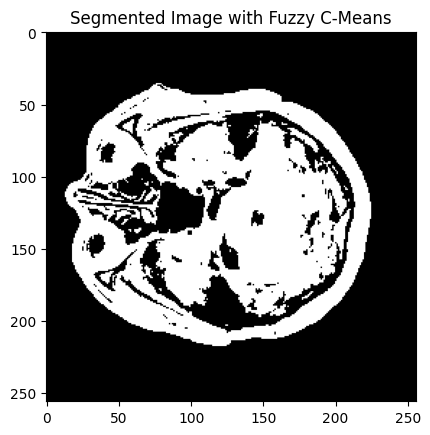

In [14]:
import skfuzzy as fuzz

def apply_fuzzy_cmeans(flattened_image, num_clusters=2):
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        flattened_image.T, num_clusters, 2, error=0.005, maxiter=1000)

    # Get the segmentation result (hard clustering from membership values)
    fcm_segmented = np.argmax(u, axis=0)
    return fcm_segmented.reshape(image_preprocessed.shape)

fcm_segmented_image = apply_fuzzy_cmeans(flattened_image, num_clusters=2)

plt.imshow(fcm_segmented_image, cmap='gray')
plt.title('Segmented Image with Fuzzy C-Means')
plt.show()


In [17]:
import cv2

# Resize the FCM segmented image to match the tumor mask shape (512, 512)
fcm_segmented_resized = cv2.resize(fcm_segmented_image, (tumor_mask.shape[1], tumor_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

print(f'Resized FCM Segmented image shape: {fcm_segmented_resized.shape}')
print(f'Tumor mask shape: {tumor_mask.shape}')

fcm_segmented_flattened = fcm_segmented_resized.flatten()
tumor_mask_flattened = tumor_mask.flatten()

def dice_coefficient(segmented, ground_truth):
    intersection = np.sum(segmented * ground_truth)
    return (2. * intersection) / (np.sum(segmented) + np.sum(ground_truth))

# Calculate the Dice Coefficient for FCM segmentation
dice_score_fcm = dice_coefficient(fcm_segmented_flattened, tumor_mask_flattened)
print(f'Dice Coefficient (FCM): {dice_score_fcm}')


Resized FCM Segmented image shape: (512, 512)
Tumor mask shape: (512, 512)
Dice Coefficient (FCM): 0.045532995481878044
